In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corrcal
import hera_sim
import healpy
from astropy import constants, units
from scipy.optimize import fmin_cg
from scipy import special
%matplotlib inline

In [2]:
def square_array(N, sep=14.6):
    array = {}
    for i in range(N):
        for j in range(N):
            array[i*N+j] = np.array([i*sep, j*sep, 0])
    return array

In [388]:
# array = square_array(4)
array = hera_sim.antpos.hex_array(3, split_core=False, outriggers=0)
channel_width = 9000
integration_time = 10.7
nu0 = 150e6

In [389]:
sim = hera_sim.Simulator(
    array_layout=array,
    Nfreqs=1,
    start_freq=nu0,
    channel_width=channel_width,
    Ntimes=1,
    start_time=2458055.3,
    integration_time=10.7,
)

In [390]:
# Pull some metadata for slicing through the array
uvdata = sim.data
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

Question: If I really want to respect the assumptions of CorrCal, then wouldn't the point source simulation actually draw the source amplitude from a Gaussian for each baseline?

In [391]:
# Rather than use actual data, take a few point sources.
src_za = np.array([4 * np.pi / 5, 0 * np.pi / 3])
src_az = np.array([np.pi / 3, 5 * np.pi / 3])
src_flux = np.array([0, 5], dtype=float)
src_loc = np.array(
    [
        [np.sin(za)*np.cos(az), np.sin(za)*np.sin(az), np.cos(za)]
        for za, az in zip(src_za, src_az)
    ]
)
for i, (ai, aj) in enumerate(zip(ant_1_inds, ant_2_inds)):
    bl = antpos[aj] - antpos[ai]
    sim.data.data_array[i,...] = np.sum(
        src_flux * np.exp(
            -2j * np.pi * nu0 * src_loc @ bl / constants.c.si.value
        )
    )

In [392]:
# TODO: put the code for simulating visibilities of a GRF realization here

In [393]:
# Get a copy of the perfectly-calibrated data
true_uvdata = uvdata.copy()

In [394]:
# Add some noise
Trx = np.min(src_flux) / 100
sim.add(
    "thermal_noise",
    Trx=Trx,
    omega_p=np.ones_like(sim.freqs)*2*np.pi,
    autovis=src_flux.sum(),
    channel_width=channel_width,
    integration_time=integration_time,
)

You have not specified how to seed the random state. This effect might not be exactly recoverable.


In [395]:
uvdata.select(ant_str="cross")
true_uvdata.select(ant_str="cross")

In [396]:
groups, centers, lengths = uvdata.get_redundancies()
bls_to_keep = []
for group in groups:
    if len(group) >= 5:
        bls_to_keep += group
uvdata.select(bls=bls_to_keep)
true_uvdata.select(bls=bls_to_keep)

In [397]:
# Pull the data array and the antenna metadata again.
data = uvdata.data_array[:,0,0,0].copy()
true_data = true_uvdata.data_array[:,0,0,0].copy()
ant_1_array = uvdata.ant_1_array
ant_2_array = uvdata.ant_2_array
antpos, antnums = uvdata.get_ENU_antpos()
ant_1_inds = np.zeros_like(ant_1_array)
ant_2_inds = np.zeros_like(ant_2_array)
for i, ant in enumerate(antnums):
    ant_1_inds[ant_1_array==ant] = i
    ant_2_inds[ant_2_array==ant] = i

In [398]:
# Sort the data into redundant groups.
wavelength = constants.c.si.value / nu0
uvws = (antpos[ant_2_inds] - antpos[ant_1_inds]) / wavelength
sort, edges, conj = corrcal.gridding.make_redundant_groups(*uvws.T[:2])
sorted_uvws = uvws[sort,:]
sorted_uvws[conj,:] *= -1
sorted_ant_1_inds = ant_1_inds[sort]
sorted_ant_2_inds = ant_2_inds[sort]
tmp = sorted_ant_1_inds.copy()
sorted_ant_1_inds[conj] = sorted_ant_2_inds[conj]
sorted_ant_2_inds[conj] = tmp[conj]
sorted_data = data[sort]
sorted_data[conj] = sorted_data[conj].conj()
sorted_true_data = true_data[sort]
sorted_true_data[conj] = sorted_true_data[conj].conj()

In [399]:
n_bls = true_uvdata.Nbls
split_data = np.zeros(2*n_bls, dtype=float)
split_data[::2] = sorted_data.real
split_data[1::2] = sorted_data.imag
split_true_data = np.zeros(2*n_bls, dtype=float)
split_true_data[::2] = sorted_true_data.real
split_true_data[1::2] = sorted_true_data.imag

In [400]:
# Insert a small amount of noise for invertibility.
Jy2T = 1e-26 * wavelength**2 / (2*constants.k_B.si.value*2*np.pi)
noise_amp = (src_flux.sum() + Trx/Jy2T)**2 / (channel_width*integration_time)
noise = np.eye(data.size, dtype=complex) * noise_amp
noise_diag = np.diag(noise)
split_noise = np.ones(2*n_bls, dtype=float) * noise_amp / 2  # half of variance in real/imag each

n_groups = edges.size - 1
n_src = src_flux.size
diff_mat = np.zeros((n_bls, n_groups), dtype=complex)
split_diff_mat = np.zeros((2*n_bls, n_groups), dtype=float)
bls = antpos[sorted_ant_2_inds] - antpos[sorted_ant_1_inds]
src_mat = src_flux.reshape(1, -1) * np.exp(
    -2j * np.pi * nu0 * bls @ src_loc.T / constants.c.si.value
)
split_src_mat = np.zeros((2*n_bls, n_src), dtype=float)
split_src_mat[::2] = src_mat.real
split_src_mat[1::2] = src_mat.imag

# Now mock up antenna gains.
np.random.seed(0)
n_ants = antnums.size
err = 0.05
re_gain = np.random.normal(loc=1, scale=err, size=n_ants)
im_gain = np.random.normal(loc=0, scale=err, size=n_ants)
split_gains = np.zeros((2*n_ants), dtype=float)
split_gains[::2] = re_gain
split_gains[1::2] = im_gain
gains = re_gain + 1j*im_gain
gain_mat = gains[sorted_ant_1_inds] * gains[sorted_ant_2_inds].conj()
split_gain_mat = np.zeros(2*n_bls, dtype=float)
split_gain_mat[::2] = gain_mat.real
split_gain_mat[1::2] = gain_mat.imag
check = np.zeros(2*n_bls, dtype=float)
check[::2] = split_gains[sorted_ant_1_inds*2] * split_gains[sorted_ant_2_inds*2] + split_gains[2*sorted_ant_1_inds+1] * split_gains[2*sorted_ant_2_inds+1]
check[1::2] = split_gains[sorted_ant_1_inds*2+1] * split_gains[sorted_ant_2_inds*2] - split_gains[sorted_ant_1_inds*2] * split_gains[sorted_ant_2_inds*2+1]
np.allclose(check, split_gain_mat)

True

In [401]:
class SplitCov:
    def __init__(self, noise, diff_mat, src_mat, gains, edges, ant_1_inds, ant_2_inds):
        self.noise = noise
        self.diff_mat = diff_mat
        self.src_mat = src_mat
        self.gains = gains
        self.edges = edges
        self.ant_1_inds = ant_1_inds
        self.ant_2_inds = ant_2_inds
        self.n_bls = diff_mat.shape[0] // 2
        self.n_grp = len(edges) - 1
        self.n_eig = diff_mat.shape[1] // (2*self.n_grp)
        self.n_src = src_mat.shape[1]
    
    def inv(self, dense=False, return_det=False):
        return self._dense_inv(return_det) if dense else self._sparse_inv(return_det)
    
    def _dense_inv(self, return_det=False):
        gain_mat = self.build_gain_mat()
        sky_cov = self.src_mat@self.src_mat.T + self.diff_mat@self.diff_mat.T
        full_cov = self.noise + gain_mat@sky_cov@gain_mat.T
        inv = np.linalg.inv(full_cov)
        if return_det:
            try:
                logdet = 2*np.sum(np.log(np.diag(np.linalg.cholesky(full_cov))))
            except np.linalg.LinAlgError:
                logdet = np.inf
            return inv, logdet
        return inv
    
    def _sparse_inv(self, return_det=False):
        if return_det:
            logdet = 0
            
        gain_mat = self.build_gain_mat()
        Cinv = np.zeros((2*self.n_bls, 2*self.n_bls), dtype=float)
        GD = gain_mat @ self.diff_mat
        for grp, (start, stop) in enumerate(zip(self.edges, self.edges[1:])):
            left = 2 * grp * self.n_eig
            right = left + 2*self.n_eig
            start = 2 * start
            stop = 2 * stop
            
            block = GD[start:stop, left:right].copy()
            block = self.noise[start:stop,start:stop] + block@block.T
            if return_det:
                logdet += 2*np.sum(np.log(np.diag(np.linalg.cholesky(block))))
            Cinv[start:stop,start:stop] = np.linalg.inv(block)
            
        GS = gain_mat @ self.src_mat
        CGS = Cinv @ GS
        tmp = np.eye(self.n_src) + GS.T@CGS
        Cinv -= CGS @ np.linalg.inv(tmp) @ CGS.T
        
        if return_det:
            logdet += 2 * np.sum(np.log(np.diag(np.linalg.cholesky(tmp))))
            return Cinv, logdet
        return Cinv
       
    def build_gain_mat(self):
        re_gains = (
            self.gains[2*self.ant_1_inds]*self.gains[2*self.ant_2_inds]
            + self.gains[2*self.ant_1_inds+1]*self.gains[2*self.ant_2_inds+1]
        )
        im_gains = (
            self.gains[2*self.ant_1_inds+1]*self.gains[2*self.ant_2_inds]
            - self.gains[2*self.ant_1_inds]*self.gains[2*self.ant_2_inds+1]
        )
        diag = np.zeros(2*self.n_bls)
        diag[::2] = re_gains
        diag[1::2] = re_gains
        off_diag = np.zeros(2*self.n_bls-1)
        off_diag[::2] = im_gains
        gain_mat = np.diag(diag) + np.diag(off_diag, -1) - np.diag(off_diag, 1)
        return gain_mat

In [478]:
def split_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Negative log-likelihood using split formulation."""
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=False, return_det=True)
    chisq = data @ cinv @ data
    # Impose a Gaussian prior on the average gain phase
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
    return chisq + logdet + phs_norm

In [485]:
def split_grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    """Gradient of negative log-likelihood using split formulation."""
    cov.gains = gains / scale
    gain_mat = cov.build_gain_mat()
    cinv = cov.inv(dense=False, return_det=False)
    cinv_data = cinv @ data
    grad_nll = np.zeros_like(gains)
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    for k in range(gains.size):
        grad_re_gain_mat = np.zeros(2*cov.n_bls, dtype=float)
        grad_im_gain_mat = np.zeros(2*cov.n_bls-1, dtype=float)
        grad_chisq = 0
        if k%2 == 0:  # derivative wrt real gain
            grad_re_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds], 0)
            grad_re_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, -cov.gains[2*cov.ant_2_inds+1], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds+1], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
        else:
            grad_re_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds+1], 0)
            grad_re_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds+1], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, -cov.gains[2*cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
        grad_re_gain_mat[1::2] = grad_re_gain_mat[::2]
        grad_gains = np.diag(grad_re_gain_mat) + np.diag(grad_im_gain_mat, -1) - np.diag(grad_im_gain_mat, 1)
        tmp1 = grad_gains @ cov.src_mat
        tmp2 = cov.src_mat.T @ gain_mat.T
        grad_cov = tmp1 @ tmp2
        tmp1 = cinv_data @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        tmp1 = grad_gains @ cov.diff_mat
        tmp2 = cov.diff_mat.T @ gain_mat.T
        grad_cov += tmp1 @ tmp2
        tmp1 = cinv_data @ tmp1
        tmp2 = tmp2 @ cinv_data
        grad_chisq += tmp1 @ tmp2
        grad_cov = grad_cov + grad_cov.T
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = grad_logdet - 2*grad_chisq + grad_phs_norm  # actually calculated -grad_chisq/2, so this is right
    return grad_nll / scale

In [486]:
def split_dense_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    cov.gains = gains / scale
    cinv, logdet = cov.inv(dense=True, return_det=True)
    chisq = data @ cinv @ data
    # Impose a Gaussian prior on the average gain phase
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    phs_norm = phases.sum()**2 / phs_norm_fac**2
    return chisq + logdet + phs_norm

In [487]:
def split_dense_grad_nll(gains, cov, data, scale=1, phs_norm_fac=1):
    cov.gains = gains / scale
    cinv = cov.inv(dense=True, return_det=False)
    gain_mat = cov.build_gain_mat()
    cinv_data = cinv @ data
    sky_cov = cov.src_mat@cov.src_mat.T + cov.diff_mat@cov.diff_mat.T
    grad_nll = np.zeros_like(gains)
    tan_phs = cov.gains[1::2] / cov.gains[::2]
    phases = np.arctan2(cov.gains[1::2], cov.gains[::2])
    grad_phs_prefac = 2 * phases.sum() / (phs_norm_fac**2 * cov.gains[::2] * (1+tan_phs**2))
    for k in range(gains.size):
        grad_re_gain_mat = np.zeros(2*cov.n_bls, dtype=float)
        grad_im_gain_mat = np.zeros(2*cov.n_bls-1, dtype=float)
        grad_chisq = 0
        if k%2 == 0:  # derivative wrt real gain
            grad_re_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds], 0)
            grad_re_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, -cov.gains[2*cov.ant_2_inds+1], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds+1], 0)
            grad_phs_norm = -grad_phs_prefac[k//2] * cov.gains[k+1] / cov.gains[k]
        else:
            grad_re_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds+1], 0)
            grad_re_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, cov.gains[2*cov.ant_1_inds+1], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_1_inds == k//2, cov.gains[2*cov.ant_2_inds], 0)
            grad_im_gain_mat[::2] += np.where(cov.ant_2_inds == k//2, -cov.gains[2*cov.ant_1_inds], 0)
            grad_phs_norm = grad_phs_prefac[k//2]
        grad_re_gain_mat[1::2] = grad_re_gain_mat[::2]
        grad_gains = np.diag(grad_re_gain_mat) + np.diag(grad_im_gain_mat, -1) - np.diag(grad_im_gain_mat, 1)
        grad_cov = grad_gains @ sky_cov @ gain_mat.T
        grad_cov = grad_cov + grad_cov.T
        grad_chisq = cinv_data @ grad_cov @ cinv_data
        grad_logdet = np.sum(cinv * grad_cov.T)
        grad_nll[k] = grad_logdet - grad_chisq + grad_phs_norm  # here we calculated -grad_chisq instead
    return grad_nll / scale

In [406]:
cov = SplitCov(
    noise=np.diag(split_noise),
    diff_mat=split_diff_mat,
    src_mat=split_src_mat,
    gains=split_gains,
    edges=edges,
    ant_1_inds=sorted_ant_1_inds,
    ant_2_inds=sorted_ant_2_inds,
)

In [407]:
gain_mat = cov.build_gain_mat()
full_cov = cov.noise + gain_mat@(cov.src_mat@cov.src_mat.T + cov.diff_mat@cov.diff_mat.T)@gain_mat.T
cinv = cov.inv(dense=False)
cinv_dense = cov.inv(dense=True)
np.allclose(full_cov @ cinv, np.eye(cinv.shape[0])), np.allclose(full_cov @ cinv, full_cov @ cinv_dense)

(True, True)

In [419]:
np.isclose(
    split_nll(split_gains, cov, split_data),
    split_dense_nll(split_gains, cov, split_data)
)

True

In [430]:
np.allclose(
    split_grad_nll(split_gains, cov, split_data),
    split_dense_grad_nll(split_gains, cov, split_data)
)

True

In [417]:
np.isclose(
    cov.inv(dense=False, return_det=True)[1],
    cov.inv(dense=True, return_det=True)[1]
)

True

In [488]:
scale = 100
phs_norm_fac = 1e-2

In [497]:
dense_fit, dense_steps = fmin_cg(
    f=split_dense_nll,
    x0=scale*split_gains,
    fprime=split_dense_grad_nll,
    args=[cov, split_data, scale, phs_norm_fac],
    retall=True,
)

         Current function value: -2187.259999
         Iterations: 66
         Function evaluations: 167
         Gradient evaluations: 154


In [496]:
sparse_fit, sparse_steps = fmin_cg(
    f=split_nll,
    x0=scale*split_gains,
    fprime=split_grad_nll,
    args=[cov, split_data, scale, phs_norm_fac],
    retall=True,
)

         Current function value: -2187.259882
         Iterations: 48
         Function evaluations: 182
         Gradient evaluations: 170


In [491]:
true_gains = np.zeros_like(split_gains)
true_gains[::2] = 1
split_nll(scale*true_gains, cov, split_data, scale, phs_norm_fac)

-2155.3842799317667

In [474]:
results = {}
for exp in np.arange(-5,6):
    alpha = 10.0**exp
    cov.gains = true_gains * alpha
    cinv, logdet = cov.inv(return_det=True)
    chisq = split_data @ cinv @ split_data
    results[alpha] = (chisq, logdet)
results

{1e-05: (25982459.677135266, -2416.3636374390494),
 0.0001: (25982459.609585643, -2416.3636374364496),
 0.001: (25981784.131088622, -2416.363611438388),
 0.01: (20620886.211414192, -2416.13251778161),
 0.1: (10231.840643219166, -2408.499947727589),
 1.0: (243.90571191203858, -2399.289991843805),
 10.0: (242.90653428264585, -2390.079651510285),
 100.0: (242.90643436326985, -2380.8693111383127),
 1000.0: (242.90643435928718, -2371.6589707663366),
 10000.0: (242.90643435928718, -2362.4486303943604),
 100000.0: (242.90643438345154, -2353.2382900223843)}

In [475]:
results = {}
for angle in np.linspace(0, 2*np.pi, 10, endpoint=False):
    test_gains = np.zeros_like(split_gains)
    test_gains[::2] = 1
    test_gains[1::2] = 0
    test_gains[0] = np.cos(angle)
    test_gains[1] = np.sin(angle)
    cov.gains = test_gains
    cinv, logdet = cov.inv(return_det=True)
    chisq = split_data @ cinv @ split_data
    results[angle] = (chisq, logdet)
results

{0.0: (243.90571191203858, -2399.289991843805),
 0.6283185307179586: (875531.3319744533, -2399.289991843805),
 1.2566370614359172: (3095084.331005144, -2399.289991843805),
 1.8849555921538759: (5696331.247178344, -2399.289991843805),
 2.5132741228718345: (7685729.277320231, -2399.289991843805),
 3.141592653589793: (8418201.7177357, -2399.289991843805),
 3.7699111843077517: (7684877.727518445, -2399.289991843805),
 4.39822971502571: (5694880.428143128, -2399.289991843805),
 5.026548245743669: (3093543.3006229238, -2399.289991843805),
 5.654866776461628: (874533.8171470399, -2399.289991843805)}

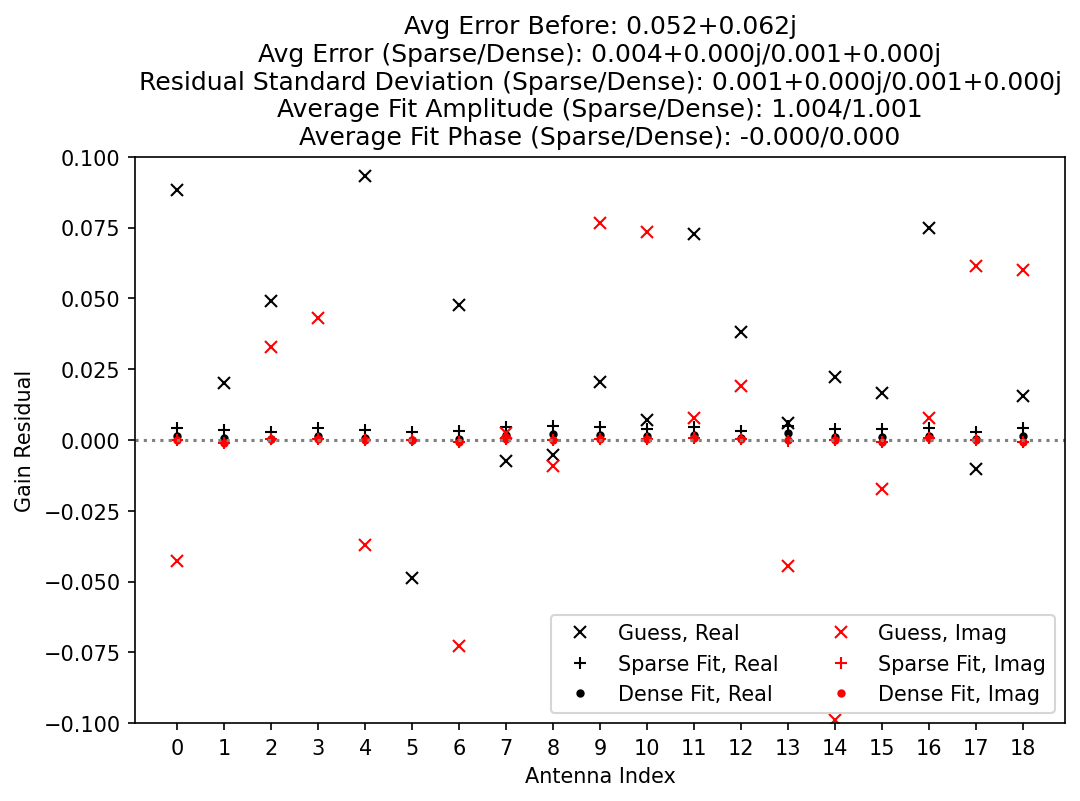

In [498]:
n_ants = gains.size
sfit = (sparse_fit[::2] + 1j*sparse_fit[1::2]) / scale
dfit = (dense_fit[::2] + 1j*dense_fit[1::2]) / scale
# If rephasing is desired:
# sfit *= sfit[0].conj() / np.abs(sfit[0])
# dfit *= dfit[0].conj() / np.abs(dfit[0])
def err(val, exp):
    return np.sqrt(np.mean((val - exp)**2))
avg_err_before = err(gains.real, 1) + 1j*err(gains.imag, 0)
avg_err_dense = err(dfit.real, 1) + 1j*err(dfit.imag, 0)
avg_err_sparse = err(sfit.real, 1) + 1j*err(sfit.imag, 0)
sfit_std = np.std(sfit.real) + 1j*np.std(sfit.imag)
dfit_std = np.std(dfit.real) + 1j*np.std(dfit.imag)
lim = 0.1
plt.figure(figsize=(8,5),dpi=150, facecolor='white')
title = f"Avg Error Before: {avg_err_before:.3f}\n"
title += f"Avg Error (Sparse/Dense): {avg_err_sparse:.3f}/{avg_err_dense:.3f}\n"
title += f"Residual Standard Deviation (Sparse/Dense): {sfit_std:.3f}/{dfit_std:.3f}\n"
title += f"Average Fit Amplitude (Sparse/Dense): {np.mean(np.abs(sfit)):.3f}/{np.mean(np.abs(dfit)):.3f}\n"
title += f"Average Fit Phase (Sparse/Dense): {np.mean(np.angle(sfit)):.3f}/{np.mean(np.angle(dfit)):.3f}"
plt.title(title)
plt.plot(gains.real - 1, 'kx', label='Guess, Real')
plt.plot(sfit.real - 1, 'k+', label='Sparse Fit, Real')
plt.plot(dfit.real - 1, 'k.', label='Dense Fit, Real')
plt.plot(gains.imag, 'rx', label='Guess, Imag')
plt.plot(sfit.imag, 'r+', label='Sparse Fit, Imag')
plt.plot(dfit.imag, 'r.', label='Dense Fit, Imag')
plt.ylim(-lim,lim)
plt.axhline(0, color='gray', ls=':')
plt.legend(ncol=2)
plt.xlabel("Antenna Index")
plt.ylabel("Gain Residual")
plt.xticks(np.arange(n_ants));
# plt.savefig(f"example_sol_comparison_split_src_mat_only_zenith_src_scale_{scale}.png", dpi=150, bbox_inches='tight')

In [499]:
# TODO: set up an MCMC to look at the nll surface